## The Dataset
  
Like several of the previous Colabs, this exercise uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

In [1]:
%tensorflow_version 2.x

In [1]:
#@title Load the imports

# from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

tf.keras.backend.set_floatx('float32')

print("Imported the modules.")

Imported the modules.


## Load, scale, and shuffle the examples

The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set

The code cell then scales the `median_house_value` to a more human-friendly range and then shuffles the examples.

In [2]:
# Load the dataset
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")



In [3]:
train_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0
...,...,...,...,...,...,...,...,...,...
16995,-124.3,40.6,52.0,2217.0,394.0,907.0,369.0,2.4,111400.0
16996,-124.3,40.7,36.0,2349.0,528.0,1194.0,465.0,2.5,79000.0
16997,-124.3,41.8,17.0,2677.0,531.0,1244.0,456.0,3.0,103600.0
16998,-124.3,41.8,19.0,2672.0,552.0,1298.0,478.0,2.0,85800.0


In [4]:
# Scale the labels
scale_factor = 1000.0
# Scale the training set's label.
train_df["median_house_value"] /= scale_factor 

# Scale the test set's label
test_df["median_house_value"] /= scale_factor

# Shuffle the examples
train_df = train_df.reindex(np.random.permutation(train_df.index))

## Represent latitude and longitude as floating-point values

Previous Colabs trained on only a single feature or a single synthetic feature. By contrast, this exercise trains on two features. Furthermore, this Colab introduces **feature columns**, which provide a sophisticated way to represent features.  

You create feature columns as possible:

  * Call a [`tf.feature_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column) method to represent a single feature, single feature cross, or single synthetic feature in the desired way.  For example, to represent a certain feature as floating-point values, call [`tf.feature_column.numeric_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column). To represent a certain feature as a series of buckets or bins, call [`tf.feature_column.bucketized_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column).
  * Assemble the created representations into a Python list. 

A neighborhood's location is typically the most important feature in determining a house's value. The California Housing dataset provides two features, `latitude` and `longitude` that identify each neighborhood's location. 

The following code cell calls [`tf.feature_column.numeric_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column) twice, first to represent `latitude` as floating-point value and a second time to represent `longitude` as floating-point values. 

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in `fp_feature_layer`) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model. 


In [5]:
train_df[['latitude', 'longitude']]

,latitude,longitude
16304,37.9,-122.5
4304,33.9,-118.0
15102,38.1,-122.3
13269,37.2,-121.9
4851,33.7,-118.1
...,...,...
2425,33.9,-117.6
2097,33.2,-117.3
13865,37.3,-122.0
9687,36.1,-119.6


In [6]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

# Create a numerical feature column to represent latitude.
latitude = tf.feature_column.numeric_column("latitude")
feature_columns.append(latitude)

# Create a numerical feature column to represent longitude.
longitude = tf.feature_column.numeric_column("longitude")
feature_columns.append(longitude)


In [8]:
latitude

NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [7]:
feature_columns

[NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [9]:

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
fp_feature_layer = layers.DenseFeatures(feature_columns)

In [10]:
fp_feature_layer

When used, the layer processes the raw inputs, according to the transformations described by the feature columns, and packs the result into a numeric array.  (The model will train on this numeric array.) 

## Define functions that create and train a model, and a plotting function

The following code defines three functions:

  * `create_model`, which tells TensorFlow to build a linear regression model and to use the `feature_layer_as_fp` as the representation of the model's features.
  * `train_model`, which will ultimately train the model from training set examples.
  * `plot_the_loss_curve`, which generates a loss curve.

In [11]:
#@title Define functions to create and train a model, and a plotting function
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model           


def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # Isolate the mean absolute error for each epoch.
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse   


def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.94, rmse.max()* 1.05])
  plt.show()  

print("Defined the create_model, train_model, and plot_the_loss_curve functions.")

Defined the create_model, train_model, and plot_the_loss_curve functions.


## Train the model with floating-point representations

The following code cell calls the functions you just created to train, plot, and evaluate a model.

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


170/170 [==============================] - 1s 2ms/step - loss: 19877.3340 - root_mean_squared_error: 140.9870
Epoch 2/30
170/170 [==============================] - 0s 2ms/step - loss: 13588.8848 - root_mean_squared_error: 116.5714
Epoch 3/30
170/170 [==============================] - 0s 2ms/step - loss: 13536.9736 - root_mean_squared_error: 116.3485
Epoch 4/30
170/170 [==============================] - 0s 2ms/step - loss: 13475.5537 - root_mean_squared_error: 116.0843
Epoch 5/30
170/170 [==============================] - 0s 2ms/step - loss: 13431.5234 - root_mean_squared_error: 115.8944
Epoch 6/30
170/170 [==============================] - 0s 2ms/step - loss: 13380.3789 - root_mean_squared_error: 115.6736
Epoch 7/30
170/170 [==============================] - 0s 2ms/step - loss: 13359.8857 - root_mean_squared_error: 115.5850
Epoch 8/30
170/170 [==============================] - 0s 2ms/step - loss: 13291.5566 - root_mean_squared_error: 115.2890
Epoch 9/30
170/170 [=======================

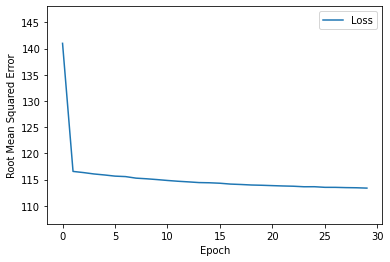


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 2ms/step - loss: 12196.7422 - root_mean_squared_error: 110.4389


[12196.7421875, 110.43885803222656]

In [12]:
# The following variables are the hyperparameters.
learning_rate = 0.05
epochs = 30
batch_size = 100
label_name = 'median_house_value'

# Create and compile the model's topography.
my_model = create_model(learning_rate, fp_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## Task 1: Why aren't floating-point values a good way to represent latitude and longitude?

Are floating-point values a good way to represent `latitude` and `longitude`? 

In [13]:
#@title Double-click to view an answer to Task 1.

# No. Representing latitude and longitude as 
# floating-point values does not have much 
# predictive power. For example, neighborhoods at 
# latitude 35 are not 36/35 more valuable 
# (or 35/36 less valuable) than houses at 
# latitude 36.

# Representing `latitude` and `longitude` as 
# floating-point values provides almost no 
# predictive power. We're only using the raw values 
# to establish a baseline for future experiments 
# with better representations.

## Represent latitude and longitude in buckets

The following code cell represents latitude and longitude in buckets (bins). Each bin represents all the neighborhoods within a single degree. For example,
neighborhoods at latitude 35.4 and 35.8 are in the same bucket, but neighborhoods in latitude 35.4 and 36.2 are in different buckets. 

The model will learn a separate weight for each bucket. For example, the model will learn one weight for all the neighborhoods in the "35" bin", a different weight for neighborhoods in the "36" bin, and so on. This representation will create approximately 20 buckets:
 
  * 10 buckets for `latitude`. 
  * 10 buckets for `longitude`. 

In [14]:
resolution_in_degrees = 1.0 

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []



In [15]:
# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(
                                          np.arange(
                                              int(min(train_df['latitude'])), 
                                              int(max(train_df['latitude'])), 
                                              resolution_in_degrees)
                                          )
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)
feature_columns.append(latitude)



In [16]:
# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(
                                                              int(min(train_df['longitude'])), 
                                                              int(max(train_df['longitude'])), 
                                                              resolution_in_degrees
                                                              )
                                            )
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)
feature_columns.append(longitude)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
buckets_feature_layer = layers.DenseFeatures(feature_columns)

## Train the model with bucket representations

Run the following code cell to train the model with bucket representations rather than floating-point representations:

Epoch 1/35


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


170/170 [==============================] - 1s 2ms/step - loss: 52293.8906 - root_mean_squared_error: 228.6786
Epoch 2/35
170/170 [==============================] - 0s 2ms/step - loss: 44865.6562 - root_mean_squared_error: 211.8151
Epoch 3/35
170/170 [==============================] - 0s 2ms/step - loss: 38242.3438 - root_mean_squared_error: 195.5565
Epoch 4/35
170/170 [==============================] - 0s 2ms/step - loss: 32434.9785 - root_mean_squared_error: 180.0971
Epoch 5/35
170/170 [==============================] - 0s 2ms/step - loss: 27378.5898 - root_mean_squared_error: 165.4648
Epoch 6/35
170/170 [==============================] - 0s 2ms/step - loss: 23113.0371 - root_mean_squared_error: 152.0297
Epoch 7/35
170/170 [==============================] - 0s 2ms/step - loss: 19564.6621 - root_mean_squared_error: 139.8737
Epoch 8/35
170/170 [==============================] - 0s 2ms/step - loss: 16750.1016 - root_mean_squared_error: 129.4222
Epoch 9/35
170/170 [=======================

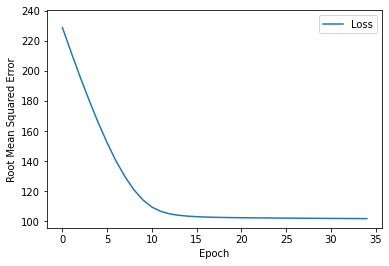


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 2ms/step - loss: 10196.6670 - root_mean_squared_error: 100.9785


[10196.6669921875, 100.97854614257812]

In [17]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the buckets_feature_layer.
my_model = create_model(learning_rate, buckets_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## Task 2: Did buckets outperform floating-point representations?

Compare the model's `root_mean_squared_error` values for the two representations (floating-point vs. buckets)?  Which model produced lower losses? 

In [18]:
#@title Double-click for an answer to Task 2.

# Bucket representation outperformed 
# floating-point representations.  
# However, you can still do far better.

## Task 3: What is a better way to represent location?

Buckets are a big improvement over floating-point values. Can you identify an even better way to identify location with `latitude` and `longitude`?

In [19]:
#@title Double-click to view an answer to Task 3.

# Representing location as a feature cross should 
# produce better results.

# In Task 2, you represented latitude in 
# one-dimensional buckets and longitude in 
# another series of one-dimensional buckets. 
# Real-world locations, however, exist in 
# two dimension. Therefore, you should
# represent location as a two-dimensional feature
# cross. That is, you'll cross the 10 or so latitude 
# buckets with the 10 or so longitude buckets to 
# create a grid of 100 cells. 

# The model will learn separate weights for each 
# of the cells.

## Represent location as a feature cross

The following code cell represents location as a feature cross. That is, the following code cell first creates buckets and then calls `tf.feature_column.crossed_column` to cross the buckets.



In [28]:
resolution_in_degrees = 0.3 

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

In [29]:
# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), int(max(train_df['latitude'])), resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)



In [30]:
# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), int(max(train_df['longitude'])), resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, longitude_boundaries)



In [31]:
# Create a feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)



In [32]:
# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_cross_feature_layer = layers.DenseFeatures(feature_columns)

Invoke the following code cell to test your solution for Task 3. Please ignore the warning messages.

Epoch 1/35


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


170/170 [==============================] - 2s 5ms/step - loss: 53693.1641 - root_mean_squared_error: 231.7178
Epoch 2/35
170/170 [==============================] - 0s 2ms/step - loss: 48919.2305 - root_mean_squared_error: 221.1769
Epoch 3/35
170/170 [==============================] - 0s 2ms/step - loss: 44465.8516 - root_mean_squared_error: 210.8693
Epoch 4/35
170/170 [==============================] - 0s 3ms/step - loss: 40291.9453 - root_mean_squared_error: 200.7285
Epoch 5/35
170/170 [==============================] - 0s 2ms/step - loss: 36436.2188 - root_mean_squared_error: 190.8827
Epoch 6/35
170/170 [==============================] - 0s 2ms/step - loss: 32893.1523 - root_mean_squared_error: 181.3647
Epoch 7/35
170/170 [==============================] - 0s 3ms/step - loss: 29613.5332 - root_mean_squared_error: 172.0858
Epoch 8/35
170/170 [==============================] - 0s 2ms/step - loss: 26649.5645 - root_mean_squared_error: 163.2469
Epoch 9/35
170/170 [=======================

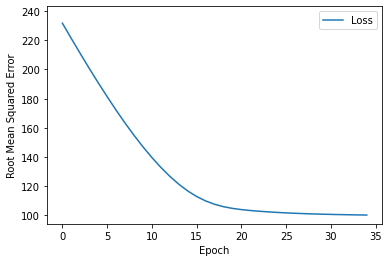


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 2ms/step - loss: 9856.8418 - root_mean_squared_error: 99.2816


[9856.841796875, 99.28163146972656]

In [39]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the feature_cross_feature_layer: 
my_model = create_model(learning_rate, feature_cross_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## Task 4: Did the feature cross outperform buckets?

Compare the model's `root_mean_squared_error` values for the two representations (buckets vs. feature cross)?  Which model produced
lower losses? 

In [34]:
#@title Double-click for an answer to this question.

# Yes, representing these features as a feature 
# cross produced much lower loss values than 
# representing these features as buckets

## Task 5: Adjust the resolution of the feature cross

Return to the code cell in the "Represent location as a feature cross" section. Notice that `resolution_in_degrees` is set to 1.0. Therefore, each cell represents an area of 1.0 degree of latitude by 1.0 degree of longitude, which corresponds to a cell of 110 km by 90 km.  This resolution defines a rather large neighborhood. 

Experiment with `resolution_in_degrees` to answer the following questions:

  1. What value of `resolution_in_degrees` produces the best results (lowest loss value)?
  2. Why does loss increase when the value of `resolution_in_degrees` drops below a certain value?

Finally, answer the following question:

  3. What feature (that does not exist in the California Housing Dataset) would
     be a better proxy for location than latitude X longitude.

In [35]:
#@title Double-click for possible answers to Task 5.

#1. A resolution of ~0.4 degree provides the best 
#   results.

#2. Below ~0.4 degree, loss increases because the 
#   dataset does not contain enough examples in 
#   each cell to accurately predict prices for 
#   those cells.

#3. Postal code would be a far better feature 
#   than latitude X longitude, assuming that 
#   the dataset contained sufficient examples 
#   in each postal code.